In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from numba import jit


Running simulation for DU=0.16, DV=0.08, f=0.035, k=0.06


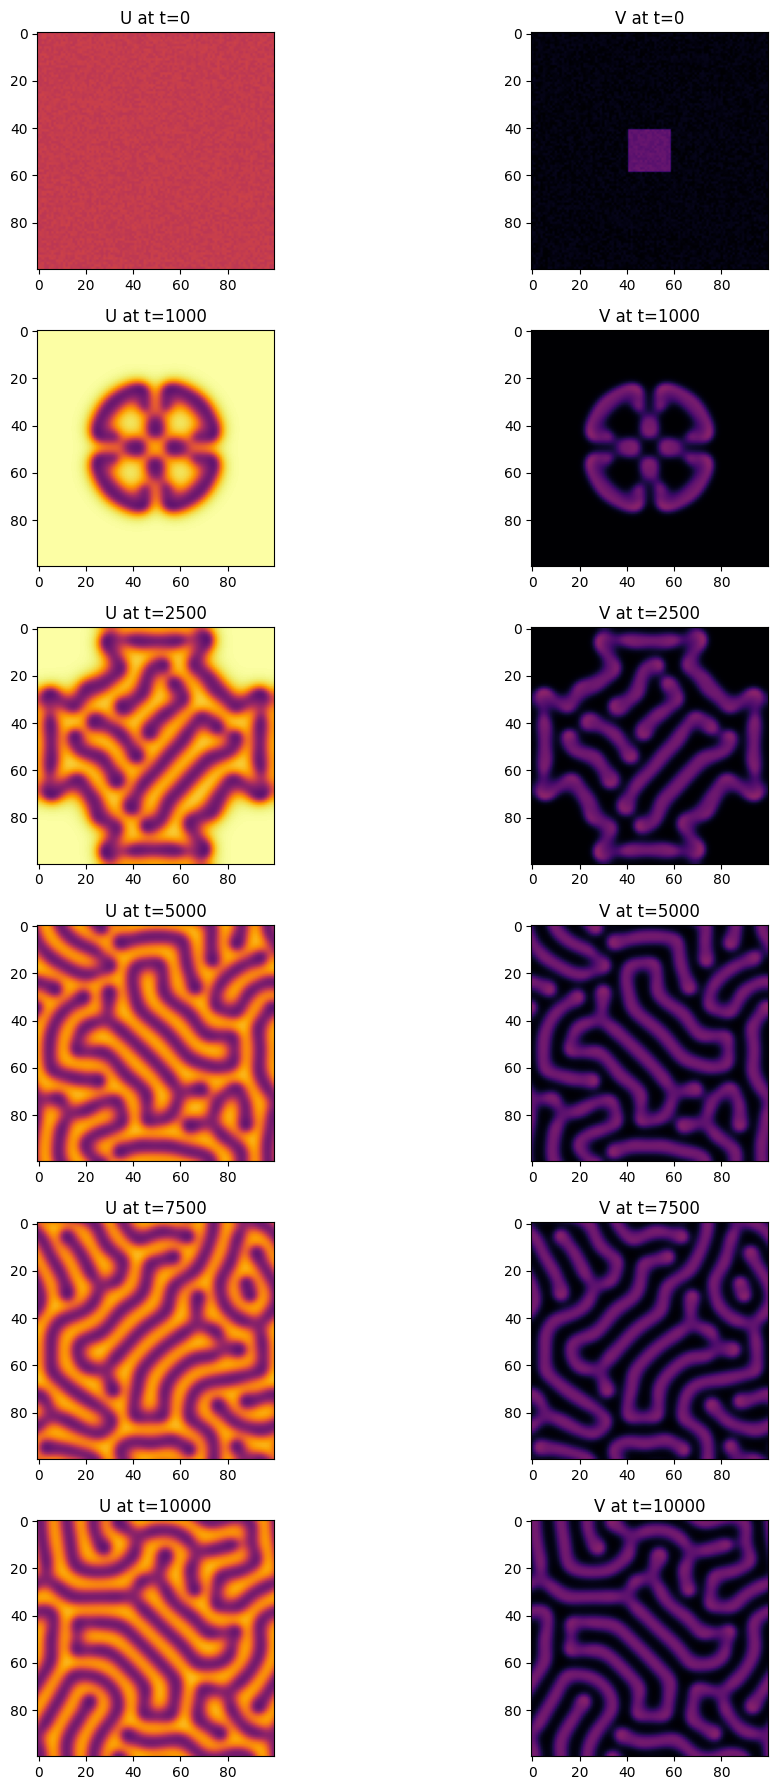

Running simulation for DU=0.14, DV=0.06, f=0.025, k=0.055


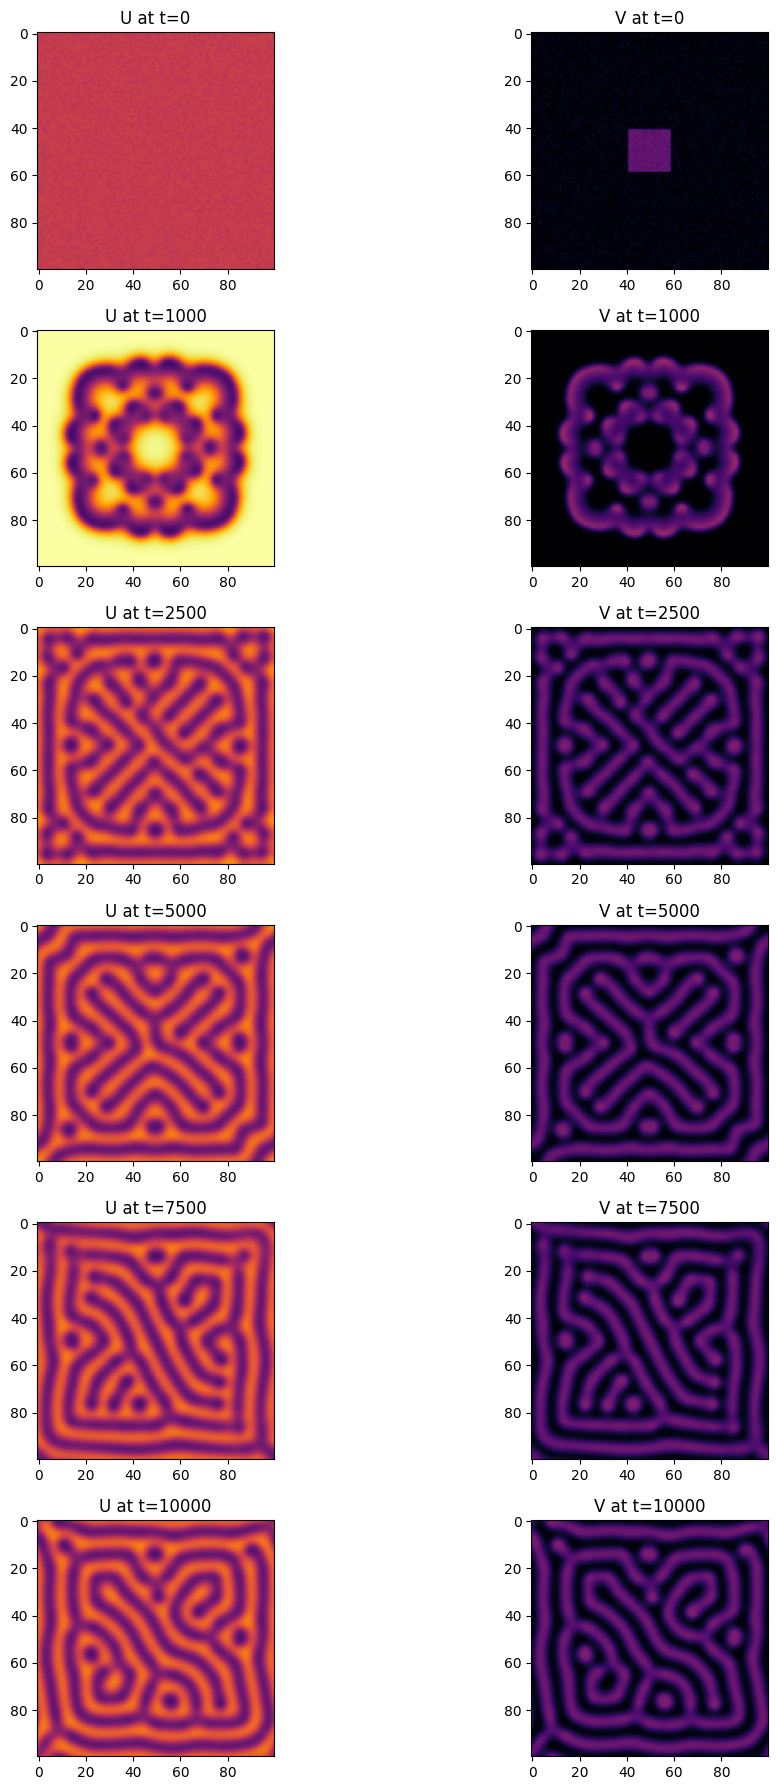

Running simulation for DU=0.18, DV=0.09, f=0.04, k=0.065


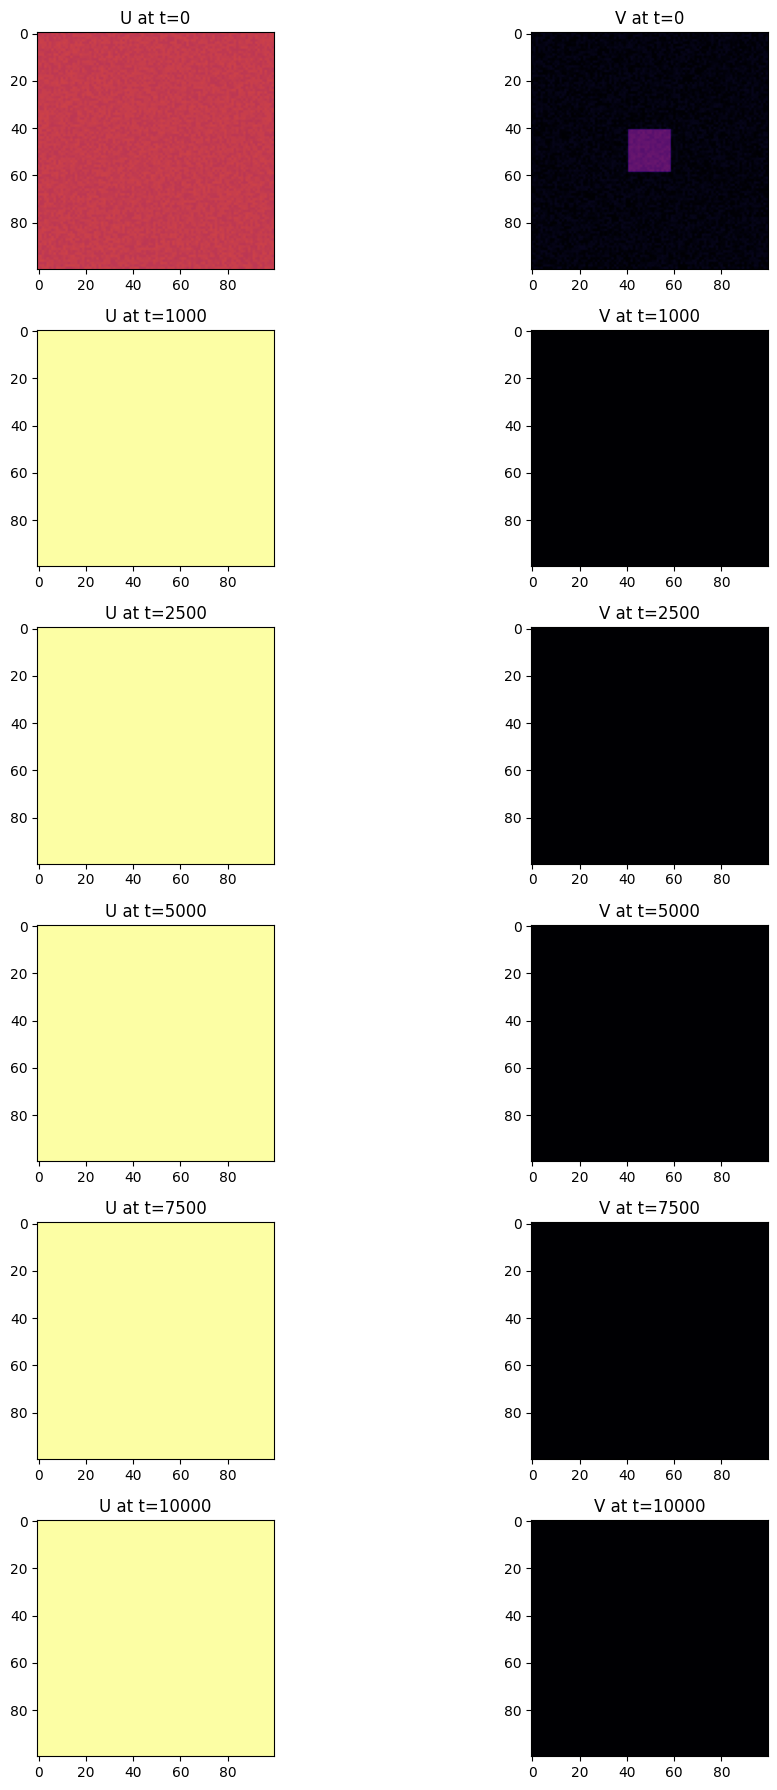

Running simulation for DU=0.16, DV=0.08, f=0.025, k=0.05


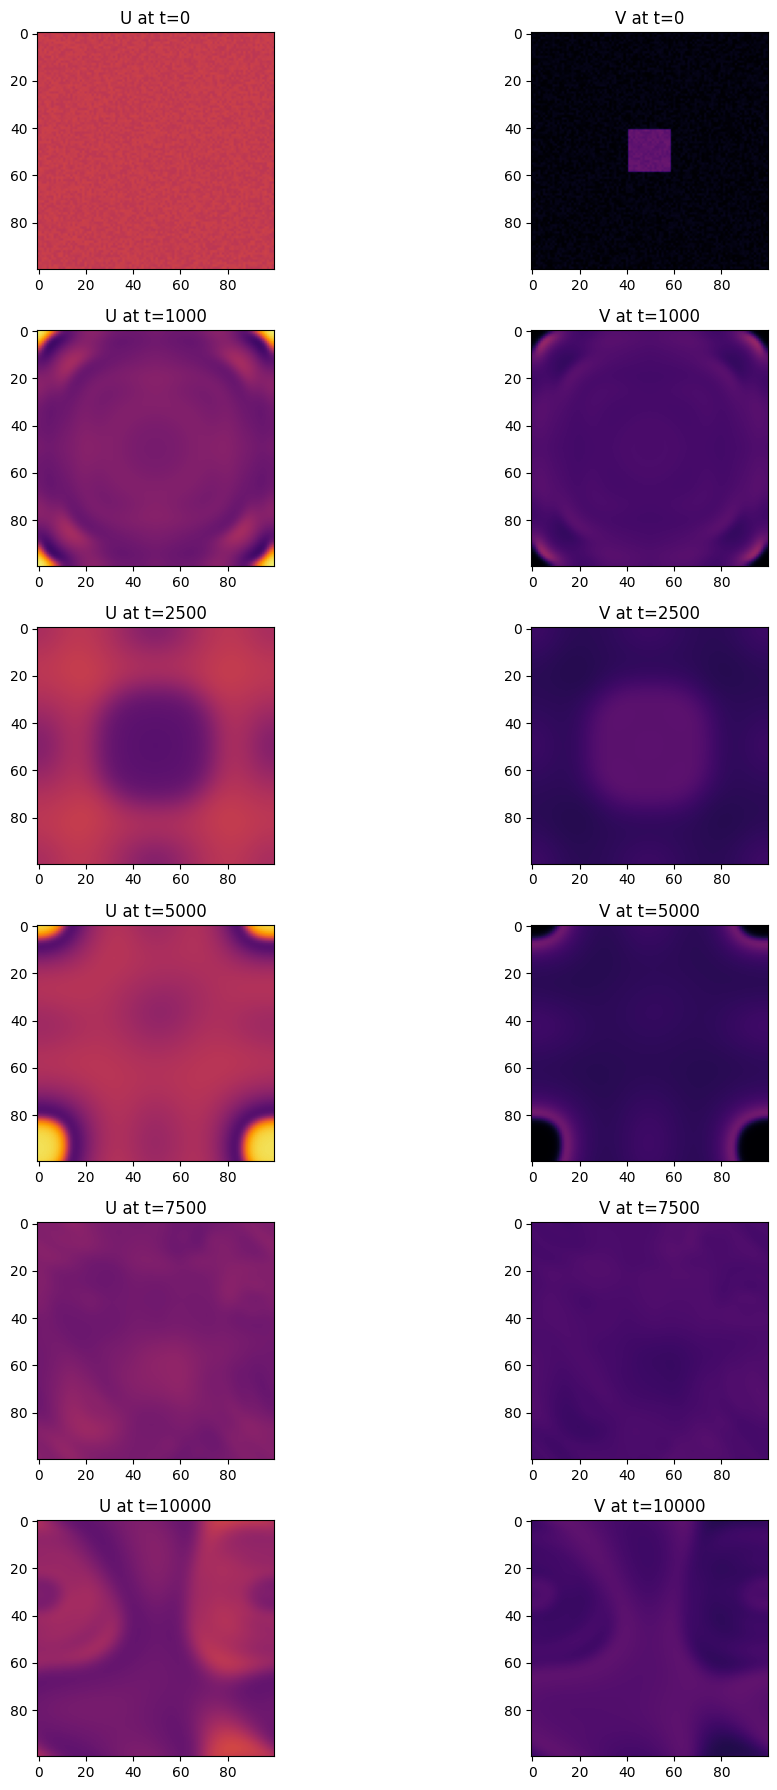

Running simulation for DU=0.16, DV=0.08, f=0.045, k=0.07


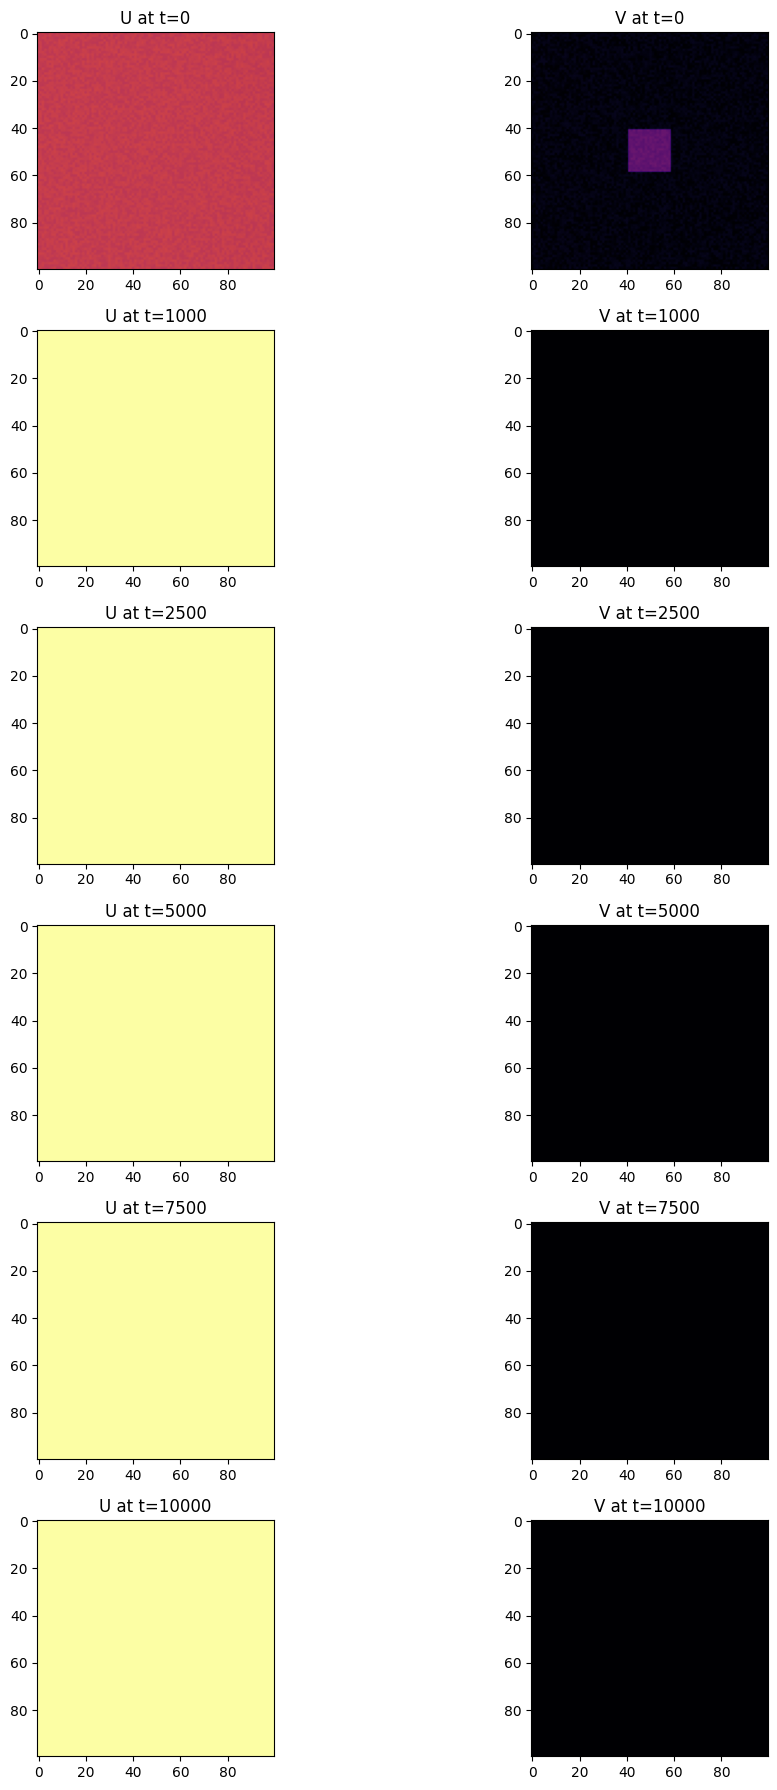

In [ ]:
GRID_SIZE = 100
DT = 1
DX = 1
DY = 1
timesteps = 10000

parameters = [
    {"DU": 0.16, "DV": 0.08, "f": 0.035, "k": 0.060},  # suggested
    {"DU": 0.14, "DV": 0.06, "f": 0.025, "k": 0.055},  # slightly lower DU, DV, f and k
    {"DU": 0.18, "DV": 0.09, "f": 0.040, "k": 0.065},  # slightly higher DU, DV, f and k - diffuses very quickly
    {"DU": 0.16, "DV": 0.08, "f": 0.025, "k": 0.050},  # same as suggested, but lower f and k
    {"DU": 0.16, "DV": 0.08, "f": 0.045, "k": 0.070},  # same as suggested, but higher f and k - diffuses very quickly
]

def initialize_grid():
    N = GRID_SIZE
    u0, v0 = 0.5, 0.25 # starting vals, u0 everywhere, v0 in the center
    U = np.ones((N, N)) * u0
    V = np.zeros((N, N))

    # square in V
    M = N // 11
    square_slice = slice(N // 2 - M, N // 2 + M)
    r = np.zeros(N)
    r[square_slice] = v0
    V[square_slice] = r

    # noise of 0.05 to both
    U += 0.05 * np.random.random((N, N))
    V += 0.05 * np.random.random((N, N))
    return U, V

@jit(nopython=True)
def update(U, V, DU, DV, f, k):
    N = GRID_SIZE
    U0 = U.copy()
    V0 = V.copy()

    for i in range(N):
        for j in range(N):
            ip = (i + 1) % N
            im = (i - 1) % N
            jp = (j + 1) % N
            jm = (j - 1) % N

            U[i, j] = U0[i, j] + DT * (DU / DX**2 * (U0[ip, j] + U0[im, j] + U0[i, jp] + U0[i, jm] - 4 * U0[i, j]) - U0[i, j] * V0[i, j]**2 + f * (1 - U0[i, j]))
            V[i, j] = V0[i, j] + DT * (DV / DX**2 * (V0[ip, j] + V0[im, j] + V0[i, jp] + V0[i, jm] - 4 * V0[i, j]) + U0[i, j] * V0[i, j]**2 - (f + k) * V0[i, j])

    return U, V

def plot(steps, save_interval, DU, DV, f, k):
    U0, V0 = initialize_grid()  # take initial state to ensure starting point is correct
    time_intervals = [0, 1000, 2500, 5000, 7500, steps] # select time points
    fig, axes = plt.subplots(len(time_intervals), 2, figsize=(12, 3 * len(time_intervals)))
    
    u_min, u_max = 0, 1  # avoid issues, maybe remove
    v_min, v_max = 0, 1

    for row_idx, t in enumerate(time_intervals):
        if t == 0:
            U, V = U0, V0
        else:
            U, V = initialize_grid()
            for _ in range(t):
                U, V = update(U, V, DU, DV, f, k)
                
        axes[row_idx, 0].imshow(U, cmap='inferno', vmin=u_min, vmax=u_max)
        axes[row_idx, 1].imshow(V, cmap='inferno', vmin=v_min, vmax=v_max)
        axes[row_idx, 0].set_title(f"U at t={t}")
        axes[row_idx, 1].set_title(f"V at t={t}")
    
    plt.tight_layout()
    plt.savefig(f"DU{DU}_DV{DV}_f{f}_k{k}.png")
    plt.show()



for parameter in parameters:
    print(f"Running simulation for DU={parameter['DU']}, DV={parameter['DV']}, f={parameter['f']}, k={parameter['k']}")
    plot(time_steps, save_interval=time_steps, **parameter)

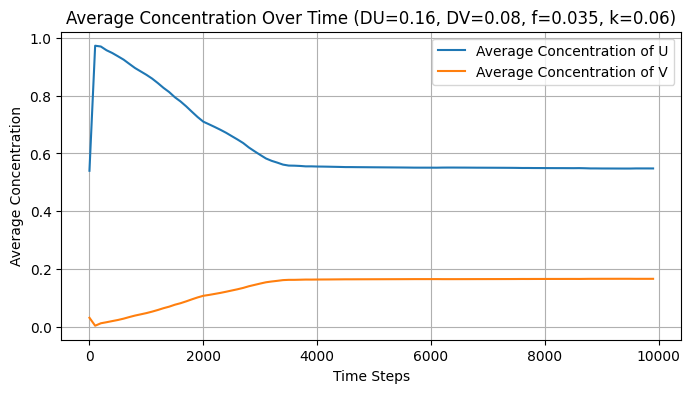

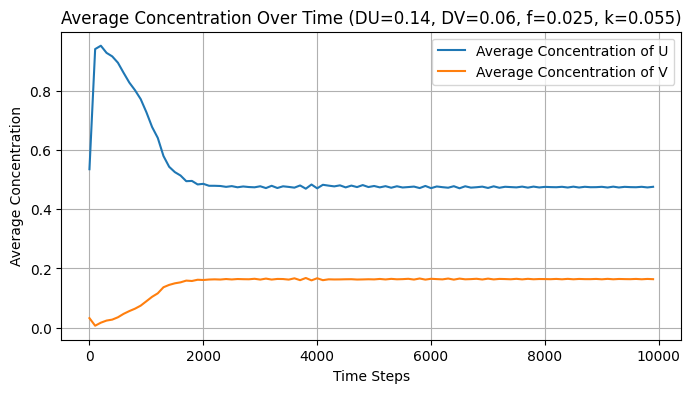

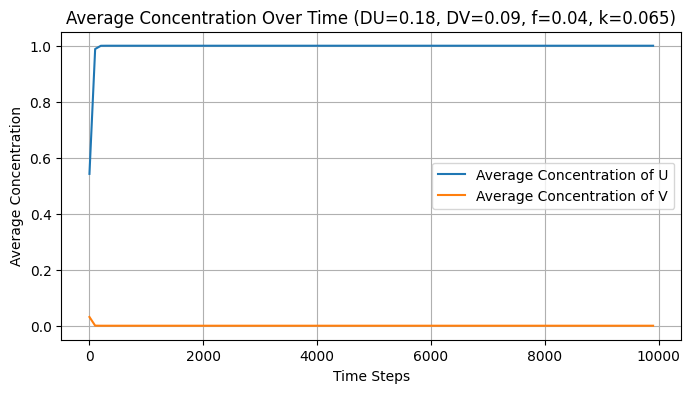

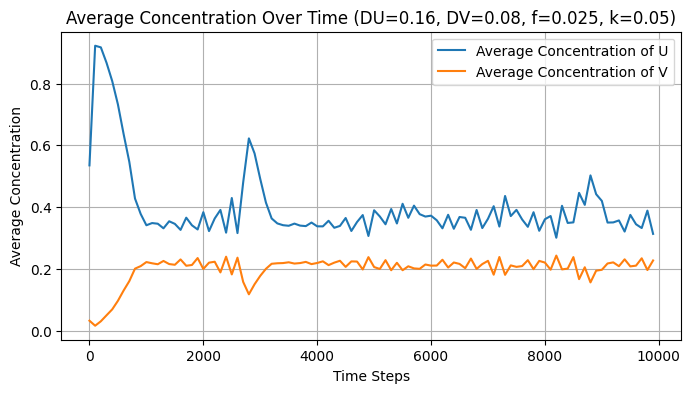

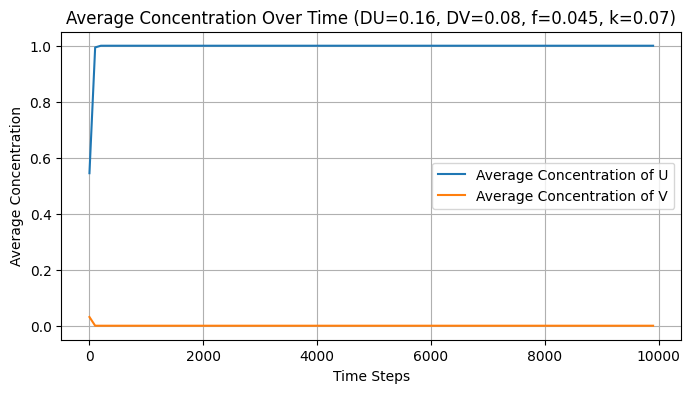

In [ ]:
def plot_avg_concentration_over_time(steps, record_interval, DU, DV, f, k):
    U, V = initialize_grid()
    avg_u = []
    avg_v = []
    times = []
    
    for t in range(steps):
        U, V = update(U, V, DU, DV, f, k)
        if t % record_interval == 0:
            times.append(t)
            avg_u.append(np.mean(U))
            avg_v.append(np.mean(V))
    
    plt.figure(figsize=(8, 4))
    plt.plot(times, avg_u, label="Average Concentration of U")
    plt.plot(times, avg_v, label="Average Concentration of V")
    plt.xlabel("Time Steps")
    plt.ylabel("Average Concentration")
    plt.title(f"Average Concentration Over Time (DU={DU}, DV={DV}, f={f}, k={k})")
    plt.legend()
    plt.grid(True)
    plt.show()

for parameter in parameters:
    plot_avg_concentration_over_time(steps=10000, record_interval=100, DU=parameter['DU'], DV=parameter['DV'], f=parameter['f'], k=parameter['k'])

